# Final Project: Examining Correlation Between COVID-19 New Cases and Unemployment Rate
# FI 8090
# Group 2: Caroline MacMillan, Chris Lee, and Jonghwa Baek

In [1]:
#Importing all the packages used in Final Project
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from yahoofinancials import YahooFinancials
from fredapi import Fred
fred = Fred(api_key='8e5b8f870e07617c9822516d2d0a2769')

C:\Users\leech\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\leech\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Retrieving the Data

In [2]:
assets = ['^GSPC'] 
predictors = ['VIXCLS', 'USEPUINDXD', 'EMVELECTGOVRN', 'TEDRATE', 
              'INDPRO','TB3MS', 'FEDFUNDS', 'UNRATE', 'DEXUSEU']
name = ['VIX', 'Uncertainty Index', 'Election Volatility', 'TED Spread',
        'Industrial Production', 'TBill', 'Federal Funds', 'Unemployment Rate', 'USD/EUR Rate']
cpredictors = ['M2', 'DCOILWTICO', 'GDP', 'CPIAUCSL']
cname = ['Money Stock', 'Oil Price', 'GDP', 'CPI']
total = pd.DataFrame()

In [3]:
#Retrieving the S&P500 data from Yahoo Finance
data = YahooFinancials(assets).get_historical_price_data(start_date = '2000-01-01', 
                                                         end_date = '2020-10-31', 
                                                         time_interval = 'daily')
prices_df = pd.DataFrame({a: {x['formatted_date']: x['adjclose'] 
                              for x in data[a]['prices']} for a in assets})
daily_returns = (((prices_df/prices_df.shift(1)) - 1) * 100).dropna()


#Retrieving all the other variables from  FRED and concatinating the to one dataframe
for p, n in zip(predictors, name):
    df = ((pd.DataFrame(fred.get_series(p, observation_start = '2000-01-01', observation_end = '2020-10-31'), 
                        columns = [n])).resample('D').mean()).interpolate(method = 'values')
    total[n] = df[n]
    
for cp, cn in zip(cpredictors, cname):
    df = ((pd.DataFrame(fred.get_series(cp, observation_start = '2000-01-01', observation_end = '2020-10-31'), 
                        columns = [cn])).resample('D').mean()).interpolate(method = 'values')
    cdf = ((df/df.shift(1))-1)*100
    total[cn] = cdf[cn]
    
totaldf = total.dropna().join(daily_returns).resample('D').mean().interpolate(method = 'values')
totaldf.head()

,VIX,Uncertainty Index,Election Volatility,TED Spread,Industrial Production,TBill,Federal Funds,Unemployment Rate,USD/EUR Rate,Money Stock,Oil Price,GDP,CPI,^GSPC
2000-01-05,26.410000,123.22,0.409832,0.750000,94.211916,5.349677,5.486129,4.012903,1.0335,0.013814,-3.560250,0.026874,0.013332,0.192218
2000-01-06,25.730000,53.61,0.409837,0.780000,94.220945,5.357097,5.495161,4.016129,1.0324,0.013812,0.567951,0.026867,0.013331,0.095568
2000-01-07,21.720000,42.03,0.409843,0.810000,94.229974,5.364516,5.504194,4.019355,1.0294,0.013810,0.000000,0.026860,0.013329,2.709040
2000-01-08,21.716667,39.10,0.409848,0.803333,94.239003,5.371935,5.513226,4.022581,1.0280,0.013808,-0.107570,0.026852,0.013327,2.179026
2000-01-09,21.713333,86.02,0.409854,0.796667,94.248032,5.379355,5.522258,4.025806,1.0266,0.013806,-0.107686,0.026845,0.013325,1.649011


In [4]:
totaldf.to_csv('data.csv') #Saving the data into a csv file.

In [5]:
data = pd.read_csv('data.csv') #Reading in the data file
total5 = data.set_index(['Unnamed: 0'])
total5.index.name = None
who = pd.read_csv('WHO-COVID-19-global-data.csv') #Reading in the COVID Data

In [6]:
data.describe()

,VIX,Uncertainty Index,Election Volatility,TED Spread,Industrial Production,TBill,Federal Funds,Unemployment Rate,USD/EUR Rate,Money Stock,Oil Price,GDP,CPI,^GSPC
count,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000
mean,19.807474,108.779746,0.841961,0.428286,99.711143,1.592924,1.744068,5.956070,1.206818,0.018272,2.074356,0.010001,0.005662,0.014504
std,8.971144,81.675562,1.061678,0.401239,5.658927,1.749831,1.892230,1.958028,0.165398,0.037313,177.558939,0.017394,0.009718,1.166208
min,9.140000,3.320000,0.000000,0.090000,87.074200,0.010000,0.050000,3.500000,0.827000,-0.217504,-124.094105,-0.114769,-0.058110,-11.984055
25%,13.510000,57.337500,0.280839,0.210000,95.100615,0.106944,0.153169,4.529032,1.107375,0.001603,-0.701403,0.007441,0.001598,-0.430648
50%,17.431667,88.230000,0.485375,0.300000,100.257415,1.028387,1.150000,5.401613,1.219300,0.015893,0.014462,0.011320,0.006231,0.060166
75%,23.296875,135.422500,1.007622,0.470000,104.135260,2.364750,2.401839,7.200000,1.329500,0.030307,0.766507,0.015010,0.010355,0.516583
max,82.690000,861.100000,8.822480,4.580000,110.551600,6.170000,6.540000,14.700000,1.601000,0.462851,15358.333333,0.092157,0.044414,11.580037


In [7]:
def hml2(df): #Function to display Heatmap of the correlations of a DataFrame. Replacing all correlations <|0.2| with 0.
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 10)

    subjective_corr = df.corr()
    mask = np.zeros_like(subjective_corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True
    subjective_corr[np.abs(subjective_corr) < .2] = 0

    sns.heatmap(subjective_corr, vmin = -1, cmap = 'coolwarm', annot = True, mask = mask)

def hmo(df): #Function to display Heatmap of the correlations of a DataFrame.
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 10)

    subjective_corr = df.corr()
    mask = np.zeros_like(subjective_corr, dtype = np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(subjective_corr, vmin = -1, cmap = 'coolwarm', annot = True, mask = mask)

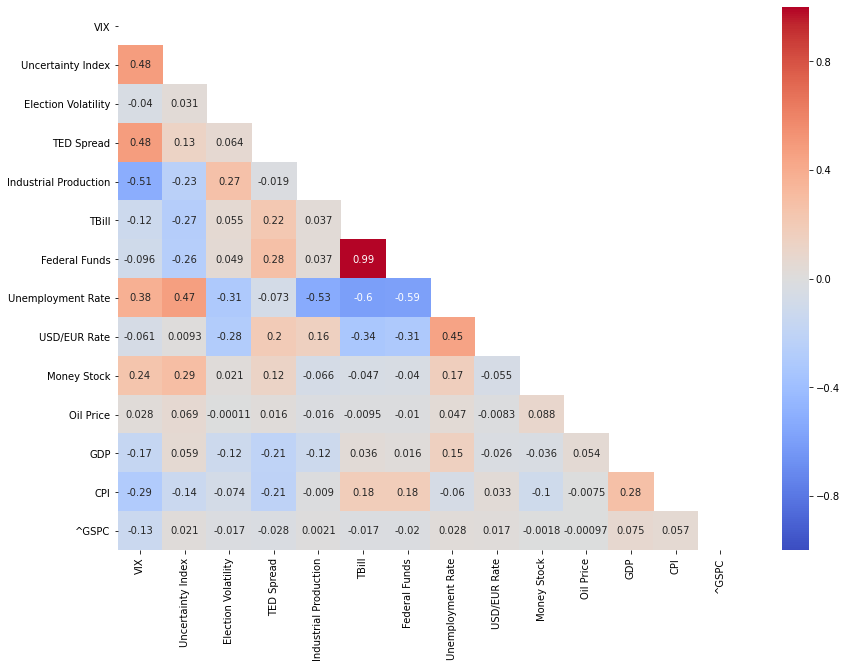

In [8]:
hmo(total5)

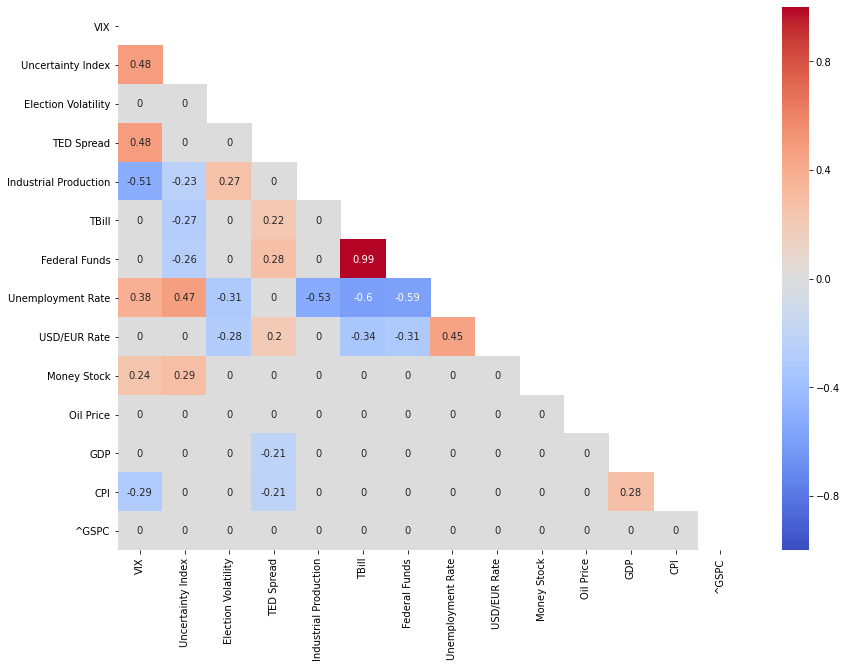

In [9]:
hml2(total5)

In [10]:
#Only pulling the USA data from the WHO COVID Data.
USA_who = who[who[' Country'] == 'United States of America'].reset_index(drop = True)
USA_who = USA_who[['Date_reported', ' New_cases', ' New_deaths']]
USA_who.to_csv('USA_who.csv')
USA_who

,Date_reported,New_cases,New_deaths
0,2020-01-03,0,0
1,2020-01-04,0,0
2,2020-01-05,0,0
3,2020-01-06,0,0
4,2020-01-07,0,0
...,...,...,...
315,2020-11-13,142076,1471
316,2020-11-14,193734,1142
317,2020-11-15,181066,1356
318,2020-11-16,155001,1216


In [11]:
#Summing the Data based on Date to create a Global COVID Data.
GLOBAL_who = who.drop(columns = [' Cumulative_cases', ' Cumulative_deaths'], axis = 1).groupby('Date_reported').sum().reset_index()
GLOBAL_who.to_csv('Global_who.csv')
GLOBAL_who

,Date_reported,New_cases,New_deaths
0,2020-01-03,0,0
1,2020-01-04,1,0
2,2020-01-05,0,0
3,2020-01-06,3,0
4,2020-01-07,0,0
...,...,...,...
315,2020-11-13,646114,9569
316,2020-11-14,665117,9956
317,2020-11-15,601845,8477
318,2020-11-16,535554,8094


In [12]:
data = data.rename(columns = {'Unnamed: 0': 'Date_reported'}) 

In [13]:
USA_merged = pd.merge(data, USA_who, on = ['Date_reported']) #Merging the COVID Data with the entire Dataset.
USA_merged.to_csv('USA_merged.csv')
USA_merged

,Date_reported,VIX,Uncertainty Index,Election Volatility,TED Spread,Industrial Production,TBill,Federal Funds,Unemployment Rate,USD/EUR Rate,Money Stock,Oil Price,GDP,CPI,^GSPC,New_cases,New_deaths
0,2020-01-03,14.020000,108.10,1.272131,0.380000,109.191732,1.520,1.551935,3.593548,1.117300,0.003819,2.991663,-0.104133,0.002867,-0.705987,0,0
1,2020-01-04,13.963333,212.82,1.314862,0.366667,109.195348,1.520,1.552903,3.590323,1.117767,0.003819,0.142857,-0.104241,0.002866,-0.352879,0,0
2,2020-01-05,13.906667,173.76,1.357593,0.353333,109.198965,1.520,1.553871,3.587097,1.118233,0.003819,0.142653,-0.104350,0.002866,0.000229,0,0
3,2020-01-06,13.850000,147.96,1.400323,0.340000,109.202581,1.520,1.554839,3.583871,1.118700,0.003819,0.142450,-0.104459,0.002866,0.353337,0,0
4,2020-01-07,13.790000,103.98,1.443054,0.370000,109.206197,1.520,1.555806,3.580645,1.113800,0.031482,-0.900901,-0.104568,0.002866,-0.280324,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2020-06-27,33.746667,276.22,1.301893,0.166667,101.197007,0.134,0.088667,10.320000,1.122233,-0.002899,0.986244,0.085389,0.019461,-1.125604,40526,2516
177,2020-06-28,32.763333,561.21,1.287520,0.163333,101.335230,0.133,0.089000,10.290000,1.122967,-0.002899,0.976613,0.085316,0.019457,0.171482,44458,650
178,2020-06-29,31.780000,301.58,1.273147,0.160000,101.473453,0.132,0.089333,10.260000,1.123700,-0.002899,0.967167,0.085244,0.019453,1.468568,44580,507
179,2020-06-30,30.430000,292.37,1.258773,0.140000,101.611677,0.131,0.089667,10.230000,1.123700,0.071387,-1.008319,0.085171,0.019449,1.540988,41008,885


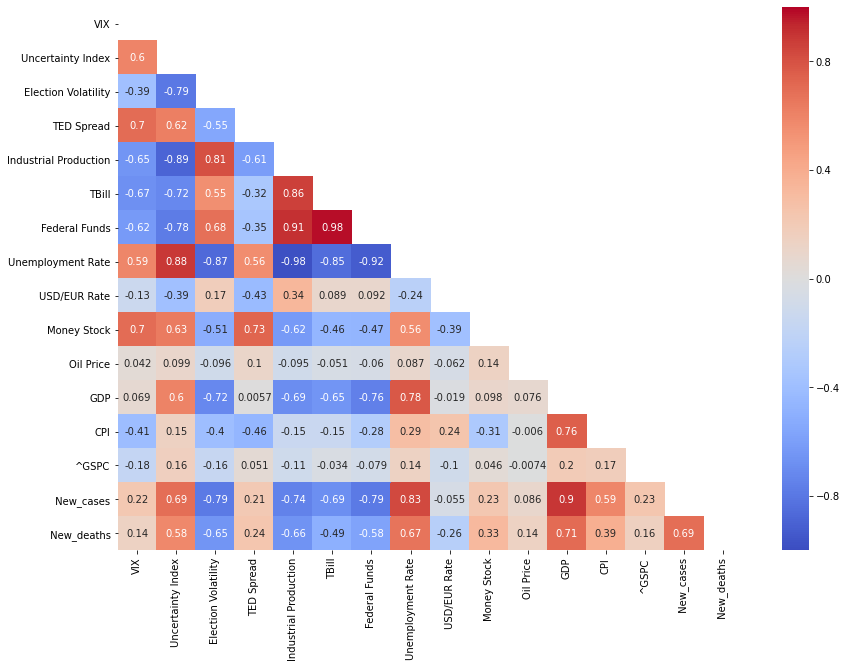

In [14]:
hmo(USA_merged)

In [15]:
GLOBAL_merged = pd.merge(data, GLOBAL_who, on = ['Date_reported']) #Merging the GLOBAL Covid Data on the entire dataset.
GLOBAL_merged.to_csv('GLOBAL_merged.csv')
GLOBAL_merged

,Date_reported,VIX,Uncertainty Index,Election Volatility,TED Spread,Industrial Production,TBill,Federal Funds,Unemployment Rate,USD/EUR Rate,Money Stock,Oil Price,GDP,CPI,^GSPC,New_cases,New_deaths
0,2020-01-03,14.020000,108.10,1.272131,0.380000,109.191732,1.520,1.551935,3.593548,1.117300,0.003819,2.991663,-0.104133,0.002867,-0.705987,0,0
1,2020-01-04,13.963333,212.82,1.314862,0.366667,109.195348,1.520,1.552903,3.590323,1.117767,0.003819,0.142857,-0.104241,0.002866,-0.352879,1,0
2,2020-01-05,13.906667,173.76,1.357593,0.353333,109.198965,1.520,1.553871,3.587097,1.118233,0.003819,0.142653,-0.104350,0.002866,0.000229,0,0
3,2020-01-06,13.850000,147.96,1.400323,0.340000,109.202581,1.520,1.554839,3.583871,1.118700,0.003819,0.142450,-0.104459,0.002866,0.353337,3,0
4,2020-01-07,13.790000,103.98,1.443054,0.370000,109.206197,1.520,1.555806,3.580645,1.113800,0.031482,-0.900901,-0.104568,0.002866,-0.280324,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2020-06-27,33.746667,276.22,1.301893,0.166667,101.197007,0.134,0.088667,10.320000,1.122233,-0.002899,0.986244,0.085389,0.019461,-1.125604,180694,6755
177,2020-06-28,32.763333,561.21,1.287520,0.163333,101.335230,0.133,0.089000,10.290000,1.122967,-0.002899,0.976613,0.085316,0.019457,0.171482,191035,4582
178,2020-06-29,31.780000,301.58,1.273147,0.160000,101.473453,0.132,0.089333,10.260000,1.123700,-0.002899,0.967167,0.085244,0.019453,1.468568,177790,4178
179,2020-06-30,30.430000,292.37,1.258773,0.140000,101.611677,0.131,0.089667,10.230000,1.123700,0.071387,-1.008319,0.085171,0.019449,1.540988,172699,3925


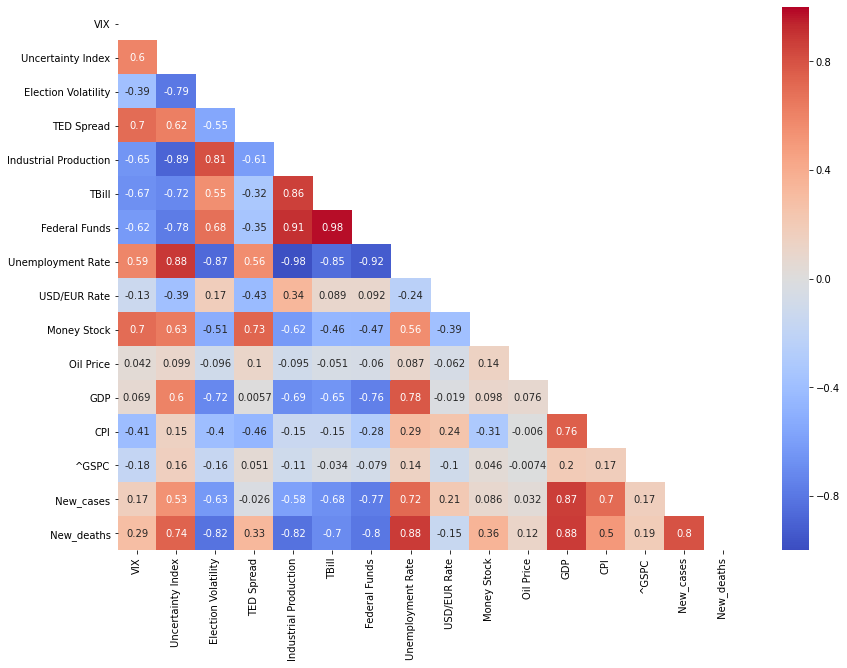

In [16]:
hmo(GLOBAL_merged)

In [17]:
preds = list(total5.columns) #Creating a list of the predictors
preds.remove('Unemployment Rate') #Removing the dependent variable from the list
preds

['VIX',
 'Uncertainty Index',
 'Election Volatility',
 'TED Spread',
 'Industrial Production',
 'TBill',
 'Federal Funds',
 'USD/EUR Rate',
 'Money Stock',
 'Oil Price',
 'GDP',
 'CPI',
 '^GSPC']

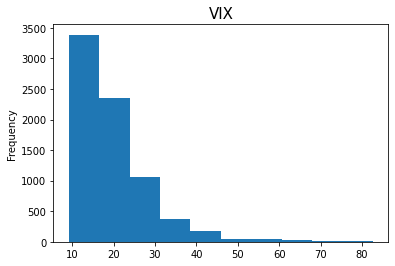

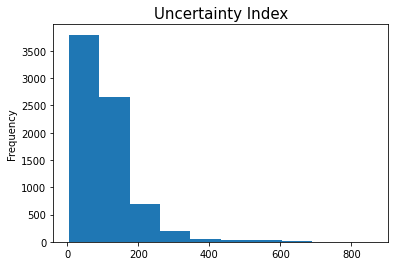

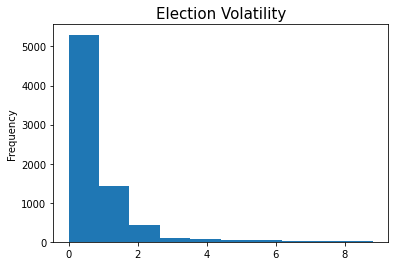

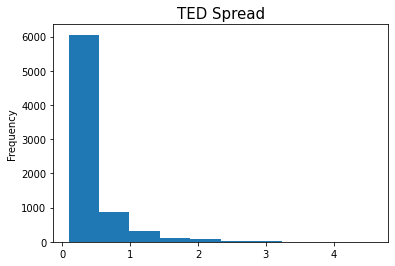

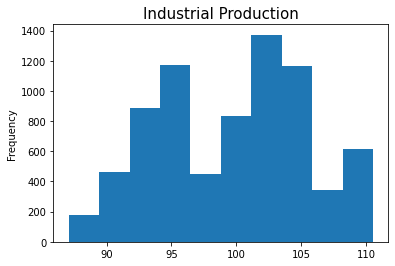

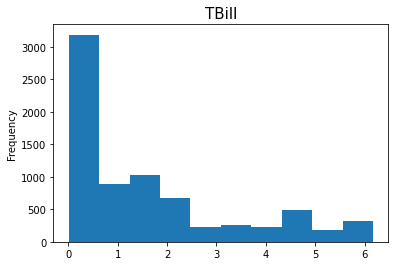

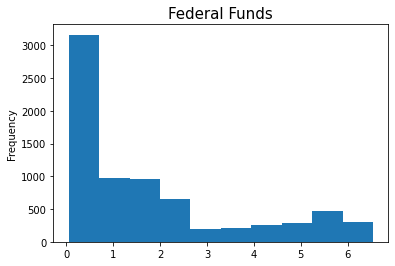

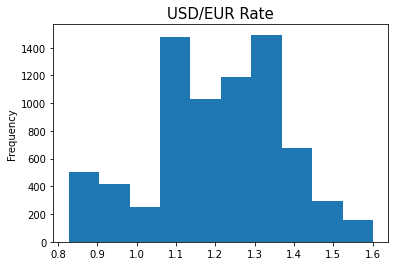

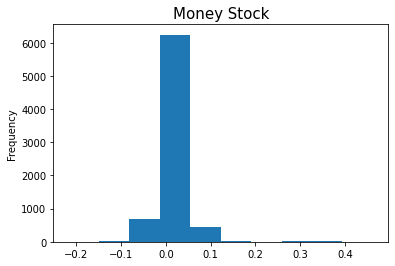

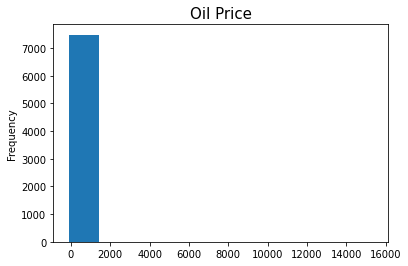

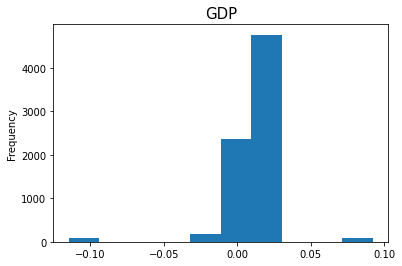

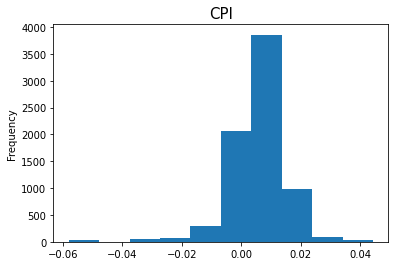

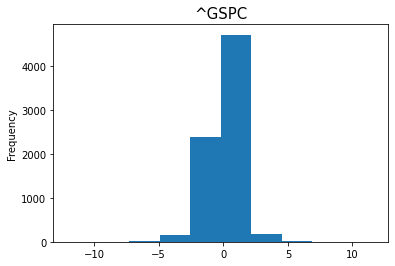

In [18]:
def indhist(feature, indTitle):
    total5[feature].plot.hist()
    plt.title(indTitle, fontsize = 15)
    plt.show()
    
for a in preds: #Original Histograms; before normalization and before merging COVID Data.
    indhist(a, a)

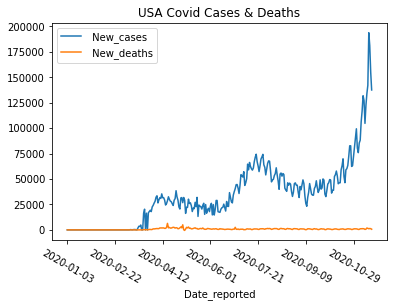

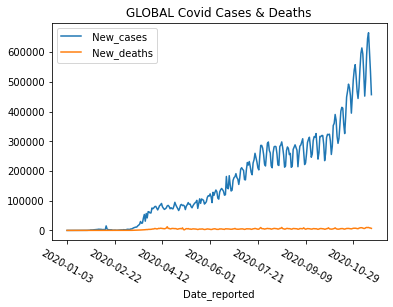

In [19]:
#Plotting the time series of USA and GLOBAL Covid data.
who_data = [USA_who, GLOBAL_who] 
who_name = ['USA Covid Cases & Deaths', 'GLOBAL Covid Cases & Deaths']
for who, titlename in zip(who_data, who_name):
    who.set_index(['Date_reported']).plot(title = titlename, rot = -30)

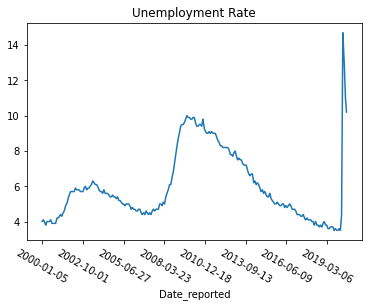

In [20]:
dataplot = data.set_index(['Date_reported'])
dataplot['Unemployment Rate'].plot(title = 'Unemployment Rate', rot = -30)

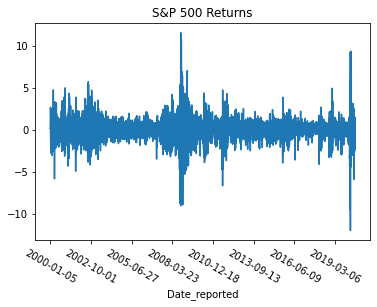

In [21]:
dataplot['^GSPC'].plot(title = 'S&P 500 Returns', rot = -30)

In [22]:
#Create variable that is 1 if the unemployment rate increases from the prior day, and 0 otherwise.
data1 = USA_merged
data1['Positive SP500 Return'] = (data1['^GSPC'] > 0).astype(int)
data1['Change to Unemployment Rate'] = (data1['Unemployment Rate']/data1['Unemployment Rate'].shift(1))-1
data1['Increase to Unemployment Rate'] = (data1['Change to Unemployment Rate'] > 0).astype(int)
data1

,Date_reported,VIX,Uncertainty Index,Election Volatility,TED Spread,Industrial Production,TBill,Federal Funds,Unemployment Rate,USD/EUR Rate,Money Stock,Oil Price,GDP,CPI,^GSPC,New_cases,New_deaths,Positive SP500 Return,Change to Unemployment Rate,Increase to Unemployment Rate
0,2020-01-03,14.020000,108.10,1.272131,0.380000,109.191732,1.520,1.551935,3.593548,1.117300,0.003819,2.991663,-0.104133,0.002867,-0.705987,0,0,0,NaN,0
1,2020-01-04,13.963333,212.82,1.314862,0.366667,109.195348,1.520,1.552903,3.590323,1.117767,0.003819,0.142857,-0.104241,0.002866,-0.352879,0,0,0,-0.000898,0
2,2020-01-05,13.906667,173.76,1.357593,0.353333,109.198965,1.520,1.553871,3.587097,1.118233,0.003819,0.142653,-0.104350,0.002866,0.000229,0,0,1,-0.000898,0
3,2020-01-06,13.850000,147.96,1.400323,0.340000,109.202581,1.520,1.554839,3.583871,1.118700,0.003819,0.142450,-0.104459,0.002866,0.353337,0,0,1,-0.000899,0
4,2020-01-07,13.790000,103.98,1.443054,0.370000,109.206197,1.520,1.555806,3.580645,1.113800,0.031482,-0.900901,-0.104568,0.002866,-0.280324,0,0,0,-0.000900,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2020-06-27,33.746667,276.22,1.301893,0.166667,101.197007,0.134,0.088667,10.320000,1.122233,-0.002899,0.986244,0.085389,0.019461,-1.125604,40526,2516,0,-0.002899,0
177,2020-06-28,32.763333,561.21,1.287520,0.163333,101.335230,0.133,0.089000,10.290000,1.122967,-0.002899,0.976613,0.085316,0.019457,0.171482,44458,650,1,-0.002907,0
178,2020-06-29,31.780000,301.58,1.273147,0.160000,101.473453,0.132,0.089333,10.260000,1.123700,-0.002899,0.967167,0.085244,0.019453,1.468568,44580,507,1,-0.002915,0
179,2020-06-30,30.430000,292.37,1.258773,0.140000,101.611677,0.131,0.089667,10.230000,1.123700,0.071387,-1.008319,0.085171,0.019449,1.540988,41008,885,1,-0.002924,0


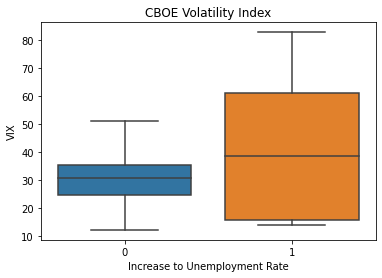

In [23]:
#Generate box plot to show relation between CBOE Volatility Index and Unemployment Rate Increases/Decreases
ax = sns.boxplot(x="Increase to Unemployment Rate", y="VIX", data= data1).set_title('CBOE Volatility Index')

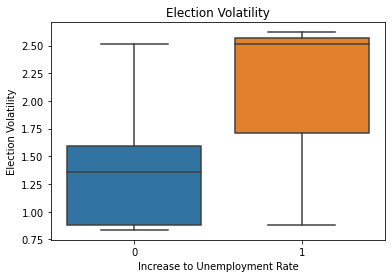

In [24]:
#Generate box plot to show relation between Election Volatility Index and Unemployment Rate Increases/Decreases
ax = sns.boxplot(x="Increase to Unemployment Rate", y="Election Volatility", data= data1).set_title('Election Volatility')

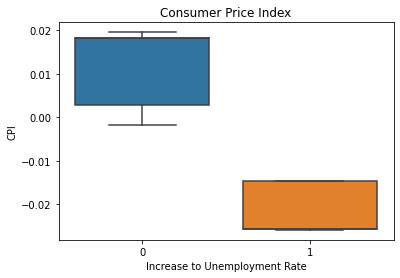

In [25]:
#Generate box plot to show relation between Consumer Price Index and Unemployment Rate Increases/Decreases
ax = sns.boxplot(x="Increase to Unemployment Rate", y="CPI", data= data1).set_title('Consumer Price Index')

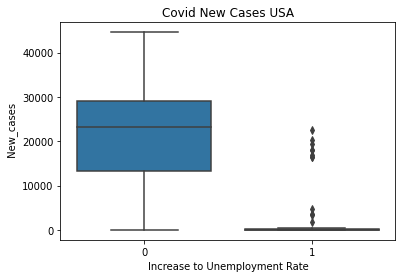

In [26]:
#Generate box plot to show relation between Covid New Cases  and Unemployment Rate Increases/Decreases
ax = sns.boxplot(x="Increase to Unemployment Rate", y=" New_cases", data= data1).set_title('Covid New Cases USA')

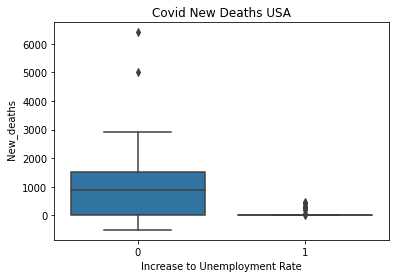

In [27]:
#Generate box plot to show relation between CBOE Volatility Index and Unemployment Rate Increases/Decreases
ax = sns.boxplot(x="Increase to Unemployment Rate", y=" New_deaths", data= data1).set_title('Covid New Deaths USA')

In [28]:
#Normalizing the skewed data.
total5['VIX v2'] = np.log(np.log(total5['VIX']))
total5['Uncertainty Index v2'] = np.log(total5['Uncertainty Index'])
total5['Election Volatility v2'] = np.log(np.log(total5['Election Volatility'] + 1) + 1)
#Money Stock - Uniform? (x-xbar)/std?
total5['TED Spread v2'] = np.log(total5['TED Spread'])
#total5['Oil Price v2'] = np.log(total5['Oil Price']) has null
#Industrial Production
#TBill
#Federal Funds - Bimodal
#total5['Unemployment Rate v2'] = np.log(total5['Unemployment Rate']) #Bimodal #Dependent Variable
#GDP - Skewed slightly, semi-normal.
#^GSPC - Normal

In [29]:
newdata = total5[['Unemployment Rate', 'VIX v2', 'Uncertainty Index v2', 'Election Volatility v2', 'Money Stock', 'TED Spread v2', 'Oil Price', 'Industrial Production', 'TBill', 'Federal Funds', 'GDP', 'CPI', 'USD/EUR Rate', '^GSPC']]
newdata

,Unemployment Rate,VIX v2,Uncertainty Index v2,Election Volatility v2,Money Stock,TED Spread v2,Oil Price,Industrial Production,TBill,Federal Funds,GDP,CPI,USD/EUR Rate,^GSPC
2000-01-05,4.012903,1.185934,4.813971,0.295256,0.013814,-0.287682,-3.560250,94.211916,5.349677,5.486129,0.026874,0.013332,1.033500,0.192218
2000-01-06,4.016129,1.177934,3.981736,0.295259,0.013812,-0.248461,0.567951,94.220945,5.357097,5.495161,0.026867,0.013331,1.032400,0.095568
2000-01-07,4.019355,1.124356,3.738384,0.295262,0.013810,-0.210721,0.000000,94.229974,5.364516,5.504194,0.026860,0.013329,1.029400,2.709040
2000-01-08,4.022581,1.124306,3.666122,0.295265,0.013808,-0.218986,-0.107570,94.239003,5.371935,5.513226,0.026852,0.013327,1.028000,2.179026
2000-01-09,4.025806,1.124256,4.454580,0.295268,0.013806,-0.227319,-0.107686,94.248032,5.379355,5.522258,0.026845,0.013325,1.026600,1.649011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,10.320000,1.258143,5.621198,0.606353,-0.002899,-1.791759,0.986244,101.197007,0.134000,0.088667,0.085389,0.019461,1.122233,-1.125604
2020-06-28,10.290000,1.249704,6.330095,0.602932,-0.002899,-1.811962,0.976613,101.335230,0.133000,0.089000,0.085316,0.019457,1.122967,0.171482
2020-06-29,10.260000,1.240932,5.709035,0.599476,-0.002899,-1.832581,0.967167,101.473453,0.132000,0.089333,0.085244,0.019453,1.123700,1.468568
2020-06-30,10.230000,1.228303,5.678020,0.595987,0.071387,-1.966113,-1.008319,101.611677,0.131000,0.089667,0.085171,0.019449,1.123700,1.540988


In [30]:
newdata.drop('Unemployment Rate', axis = 1)

,VIX v2,Uncertainty Index v2,Election Volatility v2,Money Stock,TED Spread v2,Oil Price,Industrial Production,TBill,Federal Funds,GDP,CPI,USD/EUR Rate,^GSPC
2000-01-05,1.185934,4.813971,0.295256,0.013814,-0.287682,-3.560250,94.211916,5.349677,5.486129,0.026874,0.013332,1.033500,0.192218
2000-01-06,1.177934,3.981736,0.295259,0.013812,-0.248461,0.567951,94.220945,5.357097,5.495161,0.026867,0.013331,1.032400,0.095568
2000-01-07,1.124356,3.738384,0.295262,0.013810,-0.210721,0.000000,94.229974,5.364516,5.504194,0.026860,0.013329,1.029400,2.709040
2000-01-08,1.124306,3.666122,0.295265,0.013808,-0.218986,-0.107570,94.239003,5.371935,5.513226,0.026852,0.013327,1.028000,2.179026
2000-01-09,1.124256,4.454580,0.295268,0.013806,-0.227319,-0.107686,94.248032,5.379355,5.522258,0.026845,0.013325,1.026600,1.649011
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,1.258143,5.621198,0.606353,-0.002899,-1.791759,0.986244,101.197007,0.134000,0.088667,0.085389,0.019461,1.122233,-1.125604
2020-06-28,1.249704,6.330095,0.602932,-0.002899,-1.811962,0.976613,101.335230,0.133000,0.089000,0.085316,0.019457,1.122967,0.171482
2020-06-29,1.240932,5.709035,0.599476,-0.002899,-1.832581,0.967167,101.473453,0.132000,0.089333,0.085244,0.019453,1.123700,1.468568
2020-06-30,1.228303,5.678020,0.595987,0.071387,-1.966113,-1.008319,101.611677,0.131000,0.089667,0.085171,0.019449,1.123700,1.540988


# Simple Linear Regression

In [31]:
#USA Covid Data Simple Linear Regression with New_Deaths
cx = USA_merged[' New_deaths']
cy = USA_merged['Unemployment Rate']
result = smf.ols(formula = 'cy ~ cx', data = USA_merged).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     cy   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     145.1
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           7.42e-25
Time:                        11:08:26   Log-Likelihood:                -459.34
No. Observations:                 181   AIC:                             922.7
Df Residuals:                     179   BIC:                             929.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0008      0.285     24.553      0.000       6.438       7.563
cx             0.0029      0.000     12.046      0.000       0.002       0.003
==============================================================================
Omnibus:                        1.405   Durbin-Watson:                   0.483
Prob(Omnibus):                  0.495   Jarque-Bera (JB):                1.066
Skew:                          -0.167   Prob(JB):                        0.587
Kurtosis:                       3.173   Cond. No.                     1.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
#USA Covid Data Simple Linear Regression with New_Deaths
cx = USA_merged[' New_cases']
cy = USA_merged['Unemployment Rate']
result = smf.ols(formula = 'cy ~ cx', data = USA_merged).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     cy   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     399.8
Date:                Fri, 04 Dec 2020   Prob (F-statistic):           1.74e-47
Time:                        11:08:26   Log-Likelihood:                -406.87
No. Observations:                 181   AIC:                             817.7
Df Residuals:                     179   BIC:                             824.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4975      0.247     22.279      0.000       5.011       5.984
cx             0.0002   1.25e-05     19.994      0.000       0.000       0.000
==============================================================================
Omnibus:                        5.625   Durbin-Watson:                   0.300
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                5.674
Skew:                           0.301   Prob(JB):                       0.0586
Kurtosis:                       3.624   Cond. No.                     2.85e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.85e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
ypred = result.params[1]*cx + result.params[0]

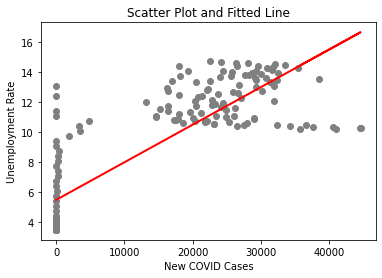

In [34]:
plt.scatter(cx, cy,  color = 'gray')
plt.plot(cx, ypred, color = 'red', linewidth = 2)
plt.title("Scatter Plot and Fitted Line")
plt.xlabel("New COVID Cases")
plt.ylabel("Unemployment Rate")
plt.show()

# Multiple Linear Regression

In [35]:
#redefining USA_merged
USA_merged = pd.merge(data, USA_who, on = ['Date_reported']) #Merging the COVID Data with the entire Dataset.

In [36]:
nd = newdata.reset_index()
ndr = nd.rename(columns = {'index': 'Date_reported'}) 
nUSA_merged = pd.merge(ndr, USA_who, on = ['Date_reported'])
nUSA_merged.head()

,Date_reported,Unemployment Rate,VIX v2,Uncertainty Index v2,Election Volatility v2,Money Stock,TED Spread v2,Oil Price,Industrial Production,TBill,Federal Funds,GDP,CPI,USD/EUR Rate,^GSPC,New_cases,New_deaths
0,2020-01-03,3.593548,0.970963,4.683057,0.599231,0.003819,-0.967584,2.991663,109.191732,1.52,1.551935,-0.104133,0.002867,1.117300,-0.705987,0,0
1,2020-01-04,3.590323,0.969428,5.360447,0.609412,0.003819,-1.003302,0.142857,109.195348,1.52,1.552903,-0.104241,0.002866,1.117767,-0.352879,0,0
2,2020-01-05,3.587097,0.967884,5.157675,0.619307,0.003819,-1.040343,0.142653,109.198965,1.52,1.553871,-0.104350,0.002866,1.118233,0.000229,0,0
3,2020-01-06,3.583871,0.966332,4.996942,0.628930,0.003819,-1.078810,0.142450,109.202581,1.52,1.554839,-0.104459,0.002866,1.118700,0.353337,0,0
4,2020-01-07,3.580645,0.964678,4.644199,0.638294,0.031482,-0.994252,-0.900901,109.206197,1.52,1.555806,-0.104568,0.002866,1.113800,-0.280324,0,0


In [37]:
y = newdata['Unemployment Rate']
X = newdata.drop(['Unemployment Rate'], axis = 1)
X = sm.add_constant(X)


model = sm.OLS(endog = y, exog = X).fit() #Testing on All with normalized Data before implementation of COVID
model.summary() #On entire Dataset, <0.01; drop CPI

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Unemployment Rate   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     2402.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        11:08:27   Log-Likelihood:                -9493.2
No. Observations:                7484   AIC:                         1.901e+04
Df Residuals:                    7470   BIC:                         1.911e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     11.3914      0.354     32.137      0.000      10.697      12.086
VIX v2                     1.9032      0.123     15.506      0.000       1.663       2.144
Uncertainty Index v2       0.4064      0.018     22.764      0.000       0.371       0.441
Election Volatility v2    -0.4609      0.058     -7.976      0.000      -0.574      -0.348
Money Stock                6.0599      0.277     21.907      0.000       5.518       6.602
TED Spread v2             -0.2441      0.023    -10.583      0.000      -0.289      -0.199
Oil Price                  0.0002   5.64e-05      3.415      0.001    8.21e-05       0.000
Industrial Production     -0.1511      0.003    -58.603      0.000      -0.156      -0.146
TBill                      0.4021      0.059      6.818      0.000       0.286       0.518
Federal Funds             -0.7247      0.055    -13.181      0.000      -0.833      -0.617
GDP                       12.5181      0.618     20.266      0.000      11.307      13.729
CPI                       -1.4256      1.115     -1.278      0.201      -3.612       0.761
USD/EUR Rate               5.0579      0.081     62.550      0.000       4.899       5.216
^GSPC                      0.0263      0.009      3.027      0.002       0.009       0.043
==============================================================================
Omnibus:                     1449.936   Durbin-Watson:                   0.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7042.637
Skew:                           0.856   Prob(JB):                         0.00
Kurtosis:                       7.433   Cond. No.                     2.01e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
#Multiple Linear Regression using both New Cases and New Deaths
y1 = USA_merged['Unemployment Rate']
#X1 = USA_merged.drop(['Unemployment Rate', 'Date_reported', 'TBill', 'Oil Price', 'USD/EUR Rate', '^GSPC'], axis = 1)
X1 = USA_merged.drop(['Unemployment Rate', 'Date_reported', 'CPI'], axis = 1)
X1 = sm.add_constant(X1)

model = sm.OLS(endog = y1, exog = X1).fit() #Testing on All with USA COVID and data not normalized.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Unemployment Rate   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.824e+04
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          1.61e-256
Time:                        11:08:27   Log-Likelihood:                 151.13
No. Observations:                 181   AIC:                            -272.3
Df Residuals:                     166   BIC:                            -224.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    39.5297      0.840     47.085      0.000      37.872      41.187
VIX                       0.0085      0.002      5.587      0.000       0.006       0.012
Uncertainty Index        -0.0002      0.000     -2.008      0.046      -0.000   -3.52e-06
Election Volatility       0.0744      0.044      1.681      0.095      -0.013       0.162
TED Spread                1.0095      0.061     16.612      0.000       0.890       1.130
Industrial Production    -0.2872      0.008    -35.878      0.000      -0.303      -0.271
TBill                     7.8988      0.168     46.918      0.000       7.566       8.231
Federal Funds           -10.0353      0.205    -48.845      0.000     -10.441      -9.630
USD/EUR Rate             -1.2548      0.769     -1.632      0.104      -2.772       0.263
Money Stock              -0.5677      0.138     -4.115      0.000      -0.840      -0.295
Oil Price             -4.625e-06   7.36e-06     -0.629      0.530   -1.91e-05     9.9e-06
GDP                      -0.0211      0.348     -0.061      0.952      -0.707       0.665
^GSPC                     0.0014      0.004      0.402      0.688      -0.006       0.008
 New_cases             1.526e-05   1.82e-06      8.398      0.000    1.17e-05    1.89e-05
 New_deaths           -5.672e-06   1.53e-05     -0.372      0.711   -3.58e-05    2.45e-05
==============================================================================
Omnibus:                        3.297   Durbin-Watson:                   0.717
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                3.146
Skew:                          -0.323   Prob(JB):                        0.207
Kurtosis:                       2.994   Cond. No.                     2.47e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
#Multiple Linear Regression using both New Cases and New Deaths
y11 = nUSA_merged['Unemployment Rate']
#X1 = USA_merged.drop(['Unemployment Rate', 'Date_reported', 'TBill', 'Oil Price', 'USD/EUR Rate', '^GSPC'], axis = 1)
X11 = nUSA_merged.drop(['Unemployment Rate', 'Date_reported', 'CPI'], axis = 1)
X11 = sm.add_constant(X11)

model = sm.OLS(endog = y11, exog = X11).fit() #Testing on All with USA COVID and normalized data.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Unemployment Rate   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     8843.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          1.93e-230
Time:                        11:08:27   Log-Likelihood:                 85.659
No. Observations:                 181   AIC:                            -141.3
Df Residuals:                     166   BIC:                            -93.34
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     41.7635      1.107     37.735      0.000      39.578      43.949
VIX v2                     1.1760      0.287      4.096      0.000       0.609       1.743
Uncertainty Index v2      -0.1205      0.043     -2.774      0.006      -0.206      -0.035
Election Volatility v2    -0.2126      0.376     -0.566      0.572      -0.954       0.529
Money Stock               -0.6079      0.195     -3.112      0.002      -0.994      -0.222
TED Spread v2              0.4099      0.058      7.102      0.000       0.296       0.524
Oil Price               1.314e-06   1.05e-05      0.125      0.901   -1.95e-05    2.21e-05
Industrial Production     -0.2709      0.014    -19.243      0.000      -0.299      -0.243
TBill                      8.5632      0.234     36.608      0.000       8.101       9.025
Federal Funds            -10.9856      0.310    -35.451      0.000     -11.597     -10.374
GDP                       -1.9757      0.458     -4.309      0.000      -2.881      -1.071
USD/EUR Rate              -4.0527      1.115     -3.634      0.000      -6.255      -1.851
^GSPC                      0.0064      0.005      1.263      0.209      -0.004       0.016
 New_cases              1.648e-05   2.69e-06      6.135      0.000    1.12e-05    2.18e-05
 New_deaths            -2.598e-05   2.17e-05     -1.195      0.234   -6.89e-05    1.69e-05
==============================================================================
Omnibus:                        8.632   Durbin-Watson:                   0.560
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                4.082
Skew:                          -0.076   Prob(JB):                        0.130
Kurtosis:                       2.280   Cond. No.                     2.23e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
#Multple Linear Regression using only New Cases as a predictor only
y2 = USA_merged['Unemployment Rate']
#X2 = USA_merged.drop(['Unemployment Rate', 'Date_reported', 'TBill', 'Oil Price', 'USD/EUR Rate', '^GSPC', ' New_deaths'], axis = 1)
X2 = USA_merged.drop(['Unemployment Rate', 'Date_reported', 'CPI', ' New_deaths'], axis = 1)
X2 = sm.add_constant(X1)

model = sm.OLS(endog = y2, exog = X2).fit() #Testing on All with USA COVID and data not normalized.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Unemployment Rate   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.824e+04
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          1.61e-256
Time:                        11:08:27   Log-Likelihood:                 151.13
No. Observations:                 181   AIC:                            -272.3
Df Residuals:                     166   BIC:                            -224.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    39.5297      0.840     47.085      0.000      37.872      41.187
VIX                       0.0085      0.002      5.587      0.000       0.006       0.012
Uncertainty Index        -0.0002      0.000     -2.008      0.046      -0.000   -3.52e-06
Election Volatility       0.0744      0.044      1.681      0.095      -0.013       0.162
TED Spread                1.0095      0.061     16.612      0.000       0.890       1.130
Industrial Production    -0.2872      0.008    -35.878      0.000      -0.303      -0.271
TBill                     7.8988      0.168     46.918      0.000       7.566       8.231
Federal Funds           -10.0353      0.205    -48.845      0.000     -10.441      -9.630
USD/EUR Rate             -1.2548      0.769     -1.632      0.104      -2.772       0.263
Money Stock              -0.5677      0.138     -4.115      0.000      -0.840      -0.295
Oil Price             -4.625e-06   7.36e-06     -0.629      0.530   -1.91e-05     9.9e-06
GDP                      -0.0211      0.348     -0.061      0.952      -0.707       0.665
^GSPC                     0.0014      0.004      0.402      0.688      -0.006       0.008
 New_cases             1.526e-05   1.82e-06      8.398      0.000    1.17e-05    1.89e-05
 New_deaths           -5.672e-06   1.53e-05     -0.372      0.711   -3.58e-05    2.45e-05
==============================================================================
Omnibus:                        3.297   Durbin-Watson:                   0.717
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                3.146
Skew:                          -0.323   Prob(JB):                        0.207
Kurtosis:                       2.994   Cond. No.                     2.47e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
#Multple Linear Regression using only New Cases as a predictor only
y22 = nUSA_merged['Unemployment Rate']
#X2 = USA_merged.drop(['Unemployment Rate', 'Date_reported', 'TBill', 'Oil Price', 'USD/EUR Rate', '^GSPC', ' New_deaths'], axis = 1)
X22 = nUSA_merged.drop(['Unemployment Rate', 'Date_reported', 'CPI', ' New_deaths'], axis = 1)
X22 = sm.add_constant(X22)

model = sm.OLS(endog = y22, exog = X22).fit() #Testing on All with USA COVID and normalized data.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Unemployment Rate   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     9499.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          3.94e-232
Time:                        11:08:27   Log-Likelihood:                 84.884
No. Observations:                 181   AIC:                            -141.8
Df Residuals:                     167   BIC:                            -96.99
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     41.4260      1.071     38.663      0.000      39.311      43.541
VIX v2                     1.1984      0.287      4.178      0.000       0.632       1.765
Uncertainty Index v2      -0.1204      0.043     -2.768      0.006      -0.206      -0.035
Election Volatility v2    -0.2116      0.376     -0.563      0.574      -0.954       0.531
Money Stock               -0.6644      0.190     -3.501      0.001      -1.039      -0.290
TED Spread v2              0.4158      0.058      7.219      0.000       0.302       0.529
Oil Price               8.677e-07   1.05e-05      0.082      0.935   -1.99e-05    2.17e-05
Industrial Production     -0.2658      0.013    -19.774      0.000      -0.292      -0.239
TBill                      8.6412      0.225     38.416      0.000       8.197       9.085
Federal Funds            -11.1122      0.292    -38.113      0.000     -11.688     -10.537
GDP                       -2.1571      0.433     -4.980      0.000      -3.012      -1.302
USD/EUR Rate              -4.2046      1.109     -3.790      0.000      -6.395      -2.014
^GSPC                      0.0068      0.005      1.343      0.181      -0.003       0.017
 New_cases              1.585e-05   2.64e-06      6.009      0.000    1.06e-05    2.11e-05
==============================================================================
Omnibus:                        7.116   Durbin-Watson:                   0.534
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                3.570
Skew:                          -0.043   Prob(JB):                        0.168
Kurtosis:                       2.318   Cond. No.                     2.22e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
#Multple Linear Regression using only New Deaths as a predictor only
y3 = USA_merged['Unemployment Rate']
#X3 = USA_merged.drop(['Unemployment Rate', 'Date_reported', 'TBill', 'Oil Price', 'USD/EUR Rate', '^GSPC', ' New_cases'], axis = 1)
X3 = USA_merged.drop(['Unemployment Rate', 'Date_reported', 'CPI', ' New_cases'], axis = 1)
X3 = sm.add_constant(X1)

model = sm.OLS(endog = y3, exog = X3).fit() #Testing on All with USA COVID and data not normalized.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Unemployment Rate   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.824e+04
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          1.61e-256
Time:                        11:08:27   Log-Likelihood:                 151.13
No. Observations:                 181   AIC:                            -272.3
Df Residuals:                     166   BIC:                            -224.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    39.5297      0.840     47.085      0.000      37.872      41.187
VIX                       0.0085      0.002      5.587      0.000       0.006       0.012
Uncertainty Index        -0.0002      0.000     -2.008      0.046      -0.000   -3.52e-06
Election Volatility       0.0744      0.044      1.681      0.095      -0.013       0.162
TED Spread                1.0095      0.061     16.612      0.000       0.890       1.130
Industrial Production    -0.2872      0.008    -35.878      0.000      -0.303      -0.271
TBill                     7.8988      0.168     46.918      0.000       7.566       8.231
Federal Funds           -10.0353      0.205    -48.845      0.000     -10.441      -9.630
USD/EUR Rate             -1.2548      0.769     -1.632      0.104      -2.772       0.263
Money Stock              -0.5677      0.138     -4.115      0.000      -0.840      -0.295
Oil Price             -4.625e-06   7.36e-06     -0.629      0.530   -1.91e-05     9.9e-06
GDP                      -0.0211      0.348     -0.061      0.952      -0.707       0.665
^GSPC                     0.0014      0.004      0.402      0.688      -0.006       0.008
 New_cases             1.526e-05   1.82e-06      8.398      0.000    1.17e-05    1.89e-05
 New_deaths           -5.672e-06   1.53e-05     -0.372      0.711   -3.58e-05    2.45e-05
==============================================================================
Omnibus:                        3.297   Durbin-Watson:                   0.717
Prob(Omnibus):                  0.192   Jarque-Bera (JB):                3.146
Skew:                          -0.323   Prob(JB):                        0.207
Kurtosis:                       2.994   Cond. No.                     2.47e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
#Multple Linear Regression using only New Deaths as a predictor only
y33 = nUSA_merged['Unemployment Rate']
#X3 = USA_merged.drop(['Unemployment Rate', 'Date_reported', 'TBill', 'Oil Price', 'USD/EUR Rate', '^GSPC', ' New_cases'], axis = 1)
X33 = nUSA_merged.drop(['Unemployment Rate', 'Date_reported', 'CPI', ' New_cases'], axis = 1)
X33 = sm.add_constant(X33)

model = sm.OLS(endog = y33, exog = X33).fit() #Testing on All with USA COVID and data not normalized.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Unemployment Rate   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     7808.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          4.95e-225
Time:                        11:08:27   Log-Likelihood:                 67.167
No. Observations:                 181   AIC:                            -106.3
Df Residuals:                     167   BIC:                            -61.56
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     41.3222      1.220     33.884      0.000      38.915      43.730
VIX v2                     1.3037      0.316      4.123      0.000       0.679       1.928
Uncertainty Index v2      -0.1364      0.048     -2.850      0.005      -0.231      -0.042
Election Volatility v2    -1.1676      0.377     -3.093      0.002      -1.913      -0.422
Money Stock               -0.8707      0.210     -4.137      0.000      -1.286      -0.455
TED Spread v2              0.4409      0.063      6.944      0.000       0.316       0.566
Oil Price               4.699e-06   1.16e-05      0.404      0.686   -1.82e-05    2.76e-05
Industrial Production     -0.2376      0.014    -16.565      0.000      -0.266      -0.209
TBill                      8.8361      0.254     34.844      0.000       8.335       9.337
Federal Funds            -11.6139      0.323    -35.961      0.000     -12.251     -10.976
GDP                       -1.3224      0.492     -2.685      0.008      -2.295      -0.350
USD/EUR Rate              -5.7304      1.194     -4.800      0.000      -8.087      -3.373
^GSPC                      0.0133      0.005      2.446      0.015       0.003       0.024
 New_deaths            -6.339e-08   2.36e-05     -0.003      0.998   -4.66e-05    4.64e-05
==============================================================================
Omnibus:                       23.227   Durbin-Watson:                   0.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.178
Skew:                          -0.240   Prob(JB):                       0.0168
Kurtosis:                       2.075   Cond. No.                     1.40e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# y2 = GLOBAL_merged['Unemployment Rate']
# X2 = GLOBAL_merged.drop(['Unemployment Rate', 'Date_reported'], axis = 1)
# X2 = sm.add_constant(X2)

# model = sm.OLS(endog = y2, exog = X2).fit() #Testing on All with GLOBAL COVID and data not normalized.
# model.summary()

# Lasso

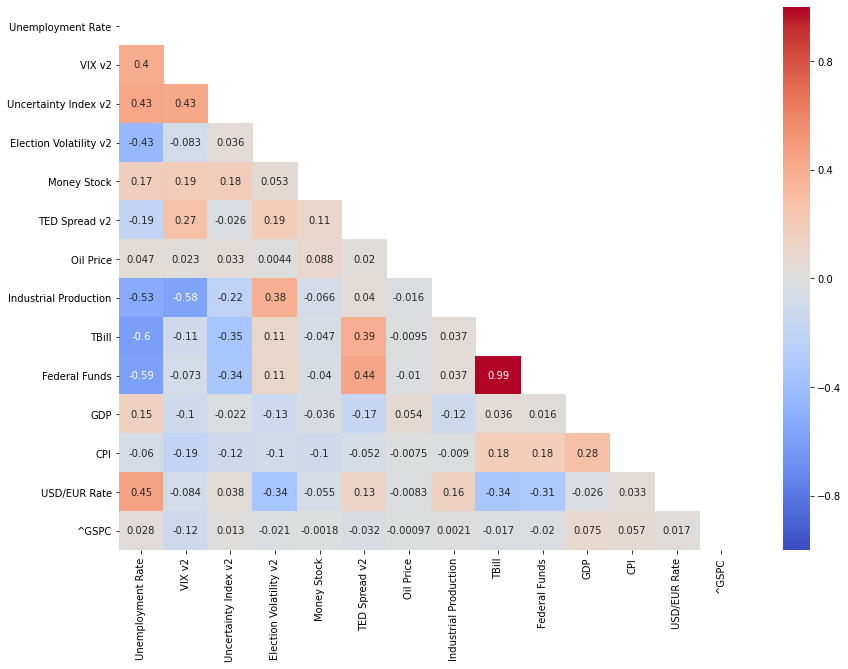

In [45]:
hmo(newdata)

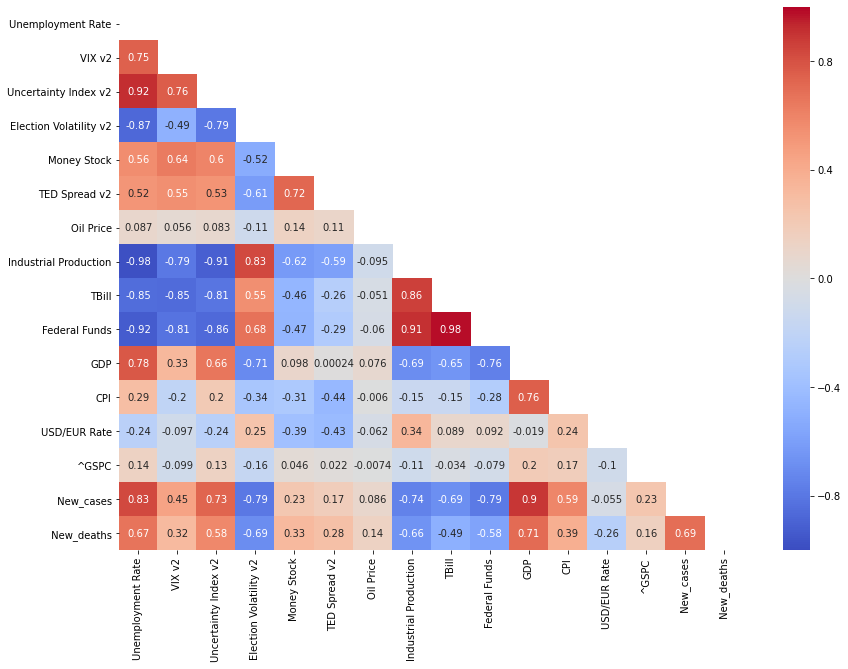

In [46]:
hmo(nUSA_merged)

In [47]:
y = newdata['Unemployment Rate']
X = newdata.drop(['Unemployment Rate'], axis = 1)

In [48]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [49]:
print('X_train:', X_train.shape) #Checking the shape of the split data.
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (5238, 13)
y_train: (5238,)
X_test: (2246, 13)
y_test: (2246,)


In [50]:
lassob = Lasso(alpha = 1, normalize = True) #Fitting a Lasso model on the training data set.
lassob.fit(X_train, y_train)    

Lasso(alpha=1, normalize=True)

In [51]:
predb = lassob.predict(X_test) #Applying the model on the test data set.
print(pd.Series(lassob.coef_, index = X.columns)) 
print("MSE is", mean_squared_error(y_test, predb)) #Calculating the MSE of this Model

VIX v2                    0.0
Uncertainty Index v2      0.0
Election Volatility v2   -0.0
Money Stock               0.0
TED Spread v2            -0.0
Oil Price                 0.0
Industrial Production    -0.0
TBill                    -0.0
Federal Funds            -0.0
GDP                       0.0
CPI                      -0.0
USD/EUR Rate              0.0
^GSPC                     0.0
dtype: float64
MSE is 3.9089029872077634


In [52]:
alphas = 10**np.linspace(10,-2,100)*0.3

In [53]:
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True) #Using CV Lasso Regression to determine the best alpha to use.
lassocv.fit(X_train, y_train) #Fitting the model.
print(lassocv.alpha_) #Displaying the lambda.
lassoc = Lasso(alpha = lassocv.alpha_, normalize = True) #Fitting Lasso model with the best lamda.
lassoc.fit(X_train, y_train)

0.003


Lasso(alpha=0.003, normalize=True)

In [54]:
predd = lassoc.predict(X_test) #Applying the lasso model with best alpha, on the test data set. 
print(pd.Series(lassoc.coef_, index = X.columns)) 
mse1d = mean_squared_error(y_test, predd)
print("MSE is", mean_squared_error(y_test, predd)) #Calculating the MSE for this model.

VIX v2                    0.160974
Uncertainty Index v2      0.299192
Election Volatility v2   -0.335120
Money Stock               0.040300
TED Spread v2            -0.000000
Oil Price                 0.000000
Industrial Production    -0.139359
TBill                    -0.000000
Federal Funds            -0.351990
GDP                       1.512423
CPI                      -0.000000
USD/EUR Rate              3.312940
^GSPC                     0.000000
dtype: float64
MSE is 1.0252037195910104


In [55]:
lasso_null = Lasso(alpha = 10**100, normalize = True) #Creating and Fitting the Null Model
lasso_null.fit(X_train, y_train)             
prede = lasso_null.predict(X_test) #Applying the null model on the test data set.
print(pd.Series(lasso_null.coef_, index = X.columns)) 
nullmse = mean_squared_error(y_test, prede)
print("MSE is", mean_squared_error(y_test, prede)) #Calculating MSE

VIX v2                    0.0
Uncertainty Index v2      0.0
Election Volatility v2   -0.0
Money Stock               0.0
TED Spread v2            -0.0
Oil Price                 0.0
Industrial Production    -0.0
TBill                    -0.0
Federal Funds            -0.0
GDP                       0.0
CPI                      -0.0
USD/EUR Rate              0.0
^GSPC                     0.0
dtype: float64
MSE is 3.9089029872077634


In [56]:
lasso_lr = Lasso(alpha = 0, normalize = True) #Creating and Fitting on the Least Squares Regression Model, Alpha = 0.
lasso_lr.fit(X_train, y_train)               
prede2 = lasso_lr.predict(X_test) #Applying the Least Squares Regression Model on the test data set.
print(pd.Series(lasso_lr.coef_, index = X.columns)) 
lsrmse = mean_squared_error(y_test, prede2)
print("MSE is", mean_squared_error(y_test, prede2)) #Calculating the MSE.

VIX v2                     1.856500
Uncertainty Index v2       0.401391
Election Volatility v2    -0.540672
Money Stock                5.334970
TED Spread v2             -0.215546
Oil Price                  0.009589
Industrial Production     -0.150545
TBill                      0.359371
Federal Funds             -0.691298
GDP                       13.573378
CPI                       -3.290711
USD/EUR Rate               4.983303
^GSPC                      0.013675
dtype: float64
MSE is 9.99985761166406


C:\Users\leech\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\Users\leech\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\leech\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1948.117515823634, tolerance: 1.991121708501741
  positive)


In [57]:
print('Lasso predicted test MSE (with the best lambda):', mse1d)
print('Null Model (lambda = infinity) test MSE:', nullmse)
print('Least Square Regression Model (lambda = 0) test MSE:', lsrmse)

Lasso predicted test MSE (with the best lambda): 1.0252037195910104
Null Model (lambda = infinity) test MSE: 3.9089029872077634
Least Square Regression Model (lambda = 0) test MSE: 9.99985761166406


In [58]:
lassoc.fit(X, y) #Fitting the Lasso Model with the best lambda with the entire data set.

coef = pd.Series(lassoc.coef_, index = X.columns)
dfzero = pd.DataFrame(coef == 0, columns = ['Zero']) #Creating the Dataframe consisting of Binary Value of the coefficients.

print(coef)
print("MSE is", mean_squared_error(y, lassoc.predict(X))) #Calculating the MSE

VIX v2                    0.006467
Uncertainty Index v2      0.275016
Election Volatility v2   -0.200732
Money Stock               0.000000
TED Spread v2            -0.000000
Oil Price                 0.000000
Industrial Production    -0.136645
TBill                    -0.000000
Federal Funds            -0.339161
GDP                       0.000000
CPI                      -0.000000
USD/EUR Rate              3.144989
^GSPC                     0.000000
dtype: float64
MSE is 1.0792243583711147


In [59]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " variables.")
print('Lasso picked:', ', '.join(list(dfzero.index[dfzero['Zero'] != True])))
print('Lasso eliminated:', ', '.join(list(dfzero.index[dfzero['Zero']])))

Lasso picked 6 variables and eliminated the other 7 variables.
Lasso picked: VIX v2, Uncertainty Index v2, Election Volatility v2, Industrial Production, Federal Funds, USD/EUR Rate
Lasso eliminated: Money Stock, TED Spread v2, Oil Price, TBill, GDP, CPI, ^GSPC


In [60]:
eliminate = list(dfzero.index[dfzero['Zero']]) #Creating a list of the features that have been reduced to zero.
eliminate

['Money Stock', 'TED Spread v2', 'Oil Price', 'TBill', 'GDP', 'CPI', '^GSPC']

In [61]:
X1 = X.drop(eliminate, axis = 1) #Dropping the features that have been reduced to zero from the Lasso model.
X1 = sm.add_constant(X1)
model = sm.OLS(y, X1).fit() #Creating and fitting a Linear Regression Model with the reduced features.
predictions = model.predict(X1)
model.summary() #Summary of the Linear Model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Unemployment Rate   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     4307.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):               0.00
Time:                        11:08:31   Log-Likelihood:                -10056.
No. Observations:                7484   AIC:                         2.013e+04
Df Residuals:                    7477   BIC:                         2.017e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     14.7439      0.331     44.577      0.000      14.095      15.392
VIX v2                     0.9360      0.114      8.218      0.000       0.713       1.159
Uncertainty Index v2       0.4720      0.019     24.776      0.000       0.435       0.509
Election Volatility v2    -0.6985      0.059    -11.765      0.000      -0.815      -0.582
Industrial Production     -0.1629      0.003    -60.355      0.000      -0.168      -0.158
Federal Funds             -0.4050      0.006    -63.686      0.000      -0.417      -0.392
USD/EUR Rate               4.4182      0.077     57.200      0.000       4.267       4.570
==============================================================================
Omnibus:                     2944.043   Durbin-Watson:                   0.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23294.857
Skew:                           1.679   Prob(JB):                         0.00
Kurtosis:                      10.964   Cond. No.                     3.18e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Lasso Model with COVID Implementation

In [62]:
eliminate

['Money Stock', 'TED Spread v2', 'Oil Price', 'TBill', 'GDP', 'CPI', '^GSPC']

In [63]:
y = nUSA_merged['Unemployment Rate']
X = nUSA_merged.drop(eliminate , axis = 1).drop(['Date_reported', 'Unemployment Rate', ' New_deaths'], axis = 1)

In [64]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [65]:
print('X_train:', X_train.shape) #Checking the shape of the split data.
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (126, 7)
y_train: (126,)
X_test: (55, 7)
y_test: (55,)


In [66]:
lassob = Lasso(alpha = 1, normalize = True) #Fitting a Lasso model on the training data set.
lassob.fit(X_train, y_train)    

Lasso(alpha=1, normalize=True)

In [67]:
predb = lassob.predict(X_test) #Applying the model on the test data set.
print(pd.Series(lassob.coef_, index = X.columns)) 
print("MSE is", mean_squared_error(y_test, predb)) #Calculating the MSE of this Model

VIX v2                    0.0
Uncertainty Index v2      0.0
Election Volatility v2   -0.0
Industrial Production    -0.0
Federal Funds            -0.0
USD/EUR Rate             -0.0
 New_cases                0.0
dtype: float64
MSE is 15.88588696894989


In [68]:
alphas = 10**np.linspace(10,-2,100)*0.3

In [69]:
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True) #Using CV Lasso Regression to determine the best alpha to use.
lassocv.fit(X_train, y_train) #Fitting the model.
print(lassocv.alpha_) #Displaying the lambda.
lassoc = Lasso(alpha = lassocv.alpha_, normalize = True) #Fitting Lasso model with the best lamda.
lassoc.fit(X_train, y_train)

0.003


Lasso(alpha=0.003, normalize=True)

In [70]:
predd = lassoc.predict(X_test) #Applying the lasso model with best alpha, on the test data set. 
print(pd.Series(lassoc.coef_, index = X.columns)) 
mse1d = mean_squared_error(y_test, predd)
print("MSE is", mean_squared_error(y_test, predd)) #Calculating the MSE for this model.

VIX v2                    0.000000
Uncertainty Index v2      0.265505
Election Volatility v2   -5.152119
Industrial Production    -0.364312
Federal Funds            -1.030347
USD/EUR Rate              2.719907
 New_cases                0.000039
dtype: float64
MSE is 0.1996503558736616


In [71]:
lasso_null = Lasso(alpha = 10**100, normalize = True) #Creating and Fitting the Null Model
lasso_null.fit(X_train, y_train)             
prede = lasso_null.predict(X_test) #Applying the null model on the test data set.
print(pd.Series(lasso_null.coef_, index = X.columns)) 
nullmse = mean_squared_error(y_test, prede)
print("MSE is", mean_squared_error(y_test, prede)) #Calculating MSE

VIX v2                    0.0
Uncertainty Index v2      0.0
Election Volatility v2   -0.0
Industrial Production    -0.0
Federal Funds            -0.0
USD/EUR Rate             -0.0
 New_cases                0.0
dtype: float64
MSE is 15.88588696894989


In [72]:
lasso_lr = Lasso(alpha = 0, normalize = True) #Creating and Fitting on the Least Squares Regression Model, Alpha = 0.
lasso_lr.fit(X_train, y_train)               
prede2 = lasso_lr.predict(X_test) #Applying the Least Squares Regression Model on the test data set.
print(pd.Series(lasso_lr.coef_, index = X.columns)) 
lsrmse = mean_squared_error(y_test, prede2)
print("MSE is", mean_squared_error(y_test, prede2)) #Calculating the MSE.

VIX v2                   -0.781867
Uncertainty Index v2      0.321666
Election Volatility v2   -4.645573
Industrial Production    -0.401920
Federal Funds            -0.948130
USD/EUR Rate              8.279430
 New_cases                0.000036
dtype: float64
MSE is 0.170627843731802


C:\Users\leech\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
C:\Users\leech\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\leech\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.90941160851502, tolerance: 0.2198048545998227
  positive)


In [73]:
print('Lasso predicted test MSE (with the best lambda):', mse1d)
print('Null Model (lambda = infinity) test MSE:', nullmse)
print('Least Square Regression Model (lambda = 0) test MSE:', lsrmse)

Lasso predicted test MSE (with the best lambda): 0.1996503558736616
Null Model (lambda = infinity) test MSE: 15.88588696894989
Least Square Regression Model (lambda = 0) test MSE: 0.170627843731802


In [74]:
lassoc.fit(X, y) #Fitting the Lasso Model with the best lambda with the entire data set.

coef = pd.Series(lassoc.coef_, index = X.columns)
dfzero = pd.DataFrame(coef == 0, columns = ['Zero']) #Creating the Dataframe consisting of Binary Value of the coefficients.

print(coef)
print("MSE is", mean_squared_error(y, lassoc.predict(X))) #Calculating the MSE

VIX v2                    0.000000
Uncertainty Index v2      0.260519
Election Volatility v2   -5.036383
Industrial Production    -0.375177
Federal Funds            -0.994996
USD/EUR Rate              5.526188
 New_cases                0.000037
dtype: float64
MSE is 0.2451019165786271


In [75]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " variables.")
print('Lasso picked:', ', '.join(list(dfzero.index[dfzero['Zero'] != True])))
print('Lasso eliminated:', ', '.join(list(dfzero.index[dfzero['Zero']])))

Lasso picked 6 variables and eliminated the other 1 variables.
Lasso picked: Uncertainty Index v2, Election Volatility v2, Industrial Production, Federal Funds, USD/EUR Rate,  New_cases
Lasso eliminated: VIX v2


In [76]:
eliminate = list(dfzero.index[dfzero['Zero']]) #Creating a list of the features that have been reduced to zero.
eliminate

['VIX v2']

In [77]:
X1 = X.drop(eliminate, axis = 1) #Dropping the features that have been reduced to zero from the Lasso model.
X1 = sm.add_constant(X1)
model = sm.OLS(y, X1).fit() #Creating and fitting a Linear Regression Model with the reduced features.
predictions = model.predict(X1)
model.summary() #Summary of the Linear Model.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Unemployment Rate   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2031.
Date:                Fri, 04 Dec 2020   Prob (F-statistic):          3.21e-158
Time:                        11:08:31   Log-Likelihood:                -127.26
No. Observations:                 181   AIC:                             268.5
Df Residuals:                     174   BIC:                             290.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     39.1579      2.866     13.664      0.000      33.502      44.814
Uncertainty Index v2       0.2811      0.126      2.225      0.027       0.032       0.530
Election Volatility v2    -4.5802      0.979     -4.678      0.000      -6.513      -2.648
Industrial Production     -0.4082      0.031    -12.962      0.000      -0.470      -0.346
Federal Funds             -0.7379      0.289     -2.553      0.012      -1.309      -0.167
USD/EUR Rate              10.8404      3.034      3.573      0.000       4.853      16.828
 New_cases              3.954e-05   6.54e-06      6.046      0.000    2.66e-05    5.24e-05
==============================================================================
Omnibus:                        9.084   Durbin-Watson:                   0.237
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                9.658
Skew:                          -0.560   Prob(JB):                      0.00799
Kurtosis:                       2.831   Cond. No.                     1.99e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
#Key Variables
newdata[['Uncertainty Index v2', 'Election Volatility v2', 'Industrial Production', 'Federal Funds', 'USD/EUR Rate']].describe()

,Uncertainty Index v2,Election Volatility v2,Industrial Production,Federal Funds,USD/EUR Rate
count,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000
mean,4.470000,0.389882,99.711143,1.744068,1.206818
std,0.666586,0.224815,5.658927,1.892230,0.165398
min,1.199965,0.000000,87.074200,0.050000,0.827000
25%,4.048955,0.221154,95.100615,0.153169,1.107375
50%,4.479947,0.333373,100.257415,1.150000,1.219300
75%,4.908400,0.528833,104.135260,2.401839,1.329500
max,6.758211,1.189267,110.551600,6.540000,1.601000
